In [3]:
!pip install shap

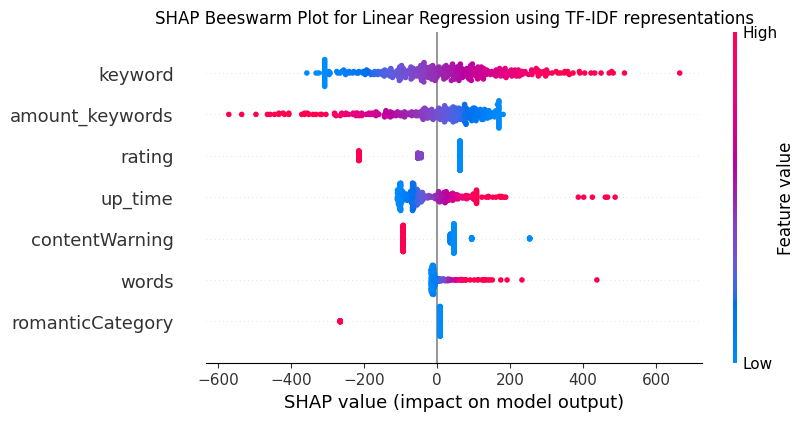

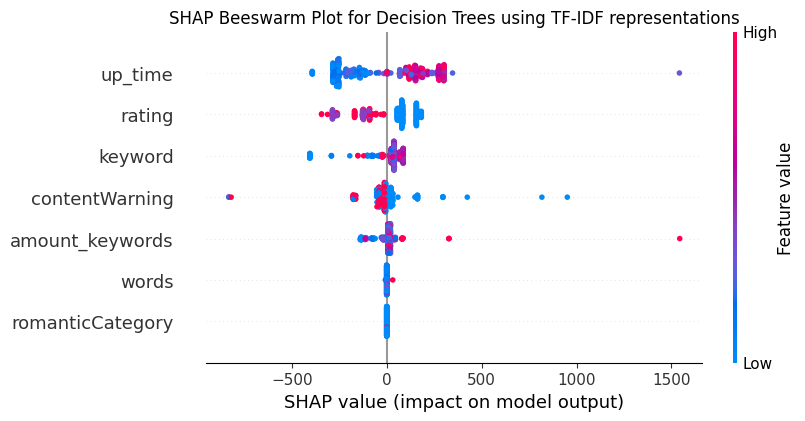

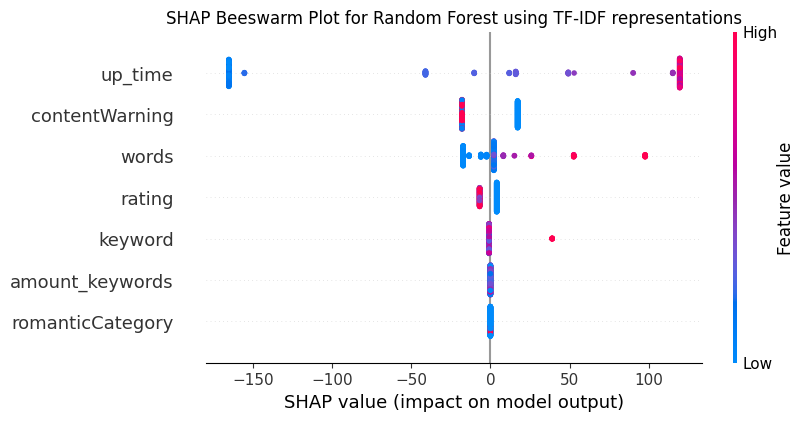

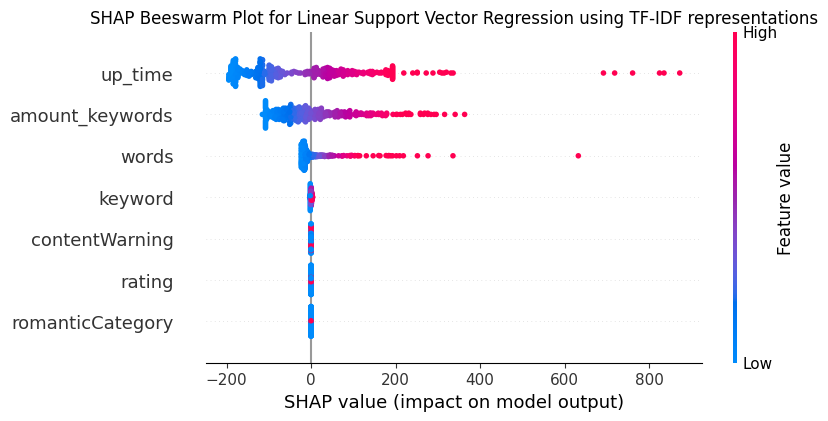

PermutationExplainer explainer: 365it [00:16,  7.38it/s]                         


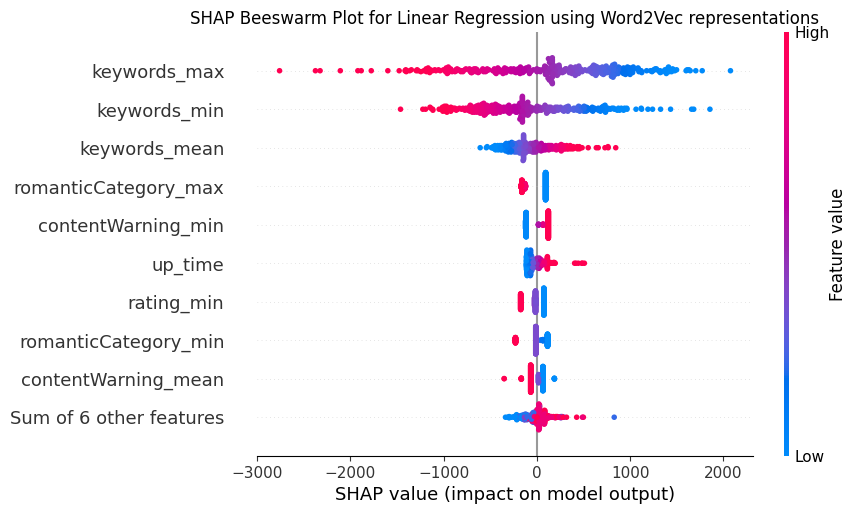

PermutationExplainer explainer: 365it [00:11,  5.21it/s]


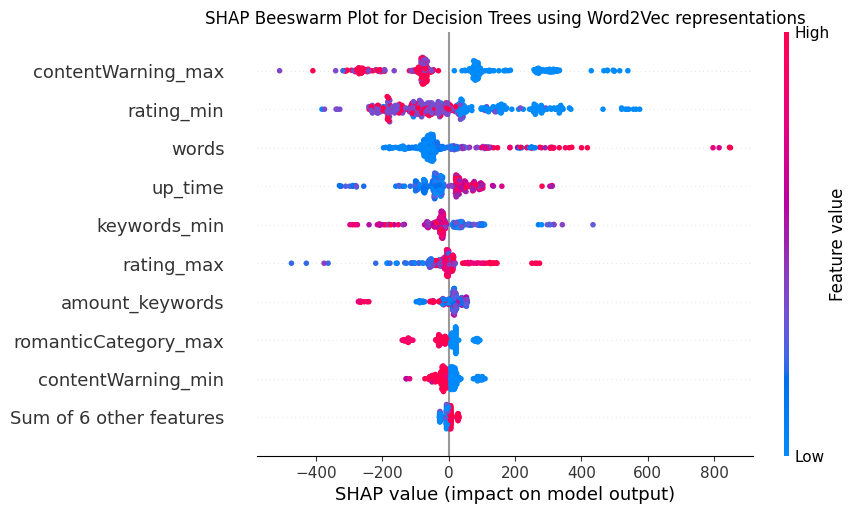

PermutationExplainer explainer: 365it [00:53,  5.47it/s]


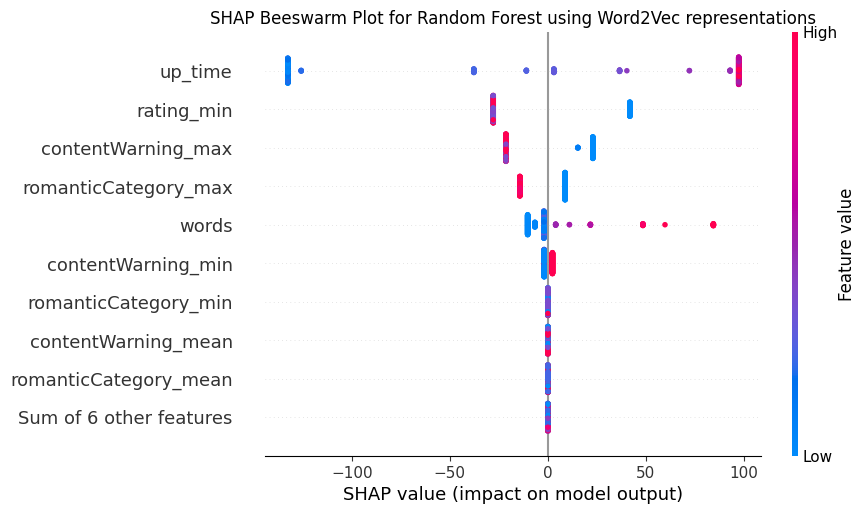

PermutationExplainer explainer: 365it [00:16,  9.19it/s]                         


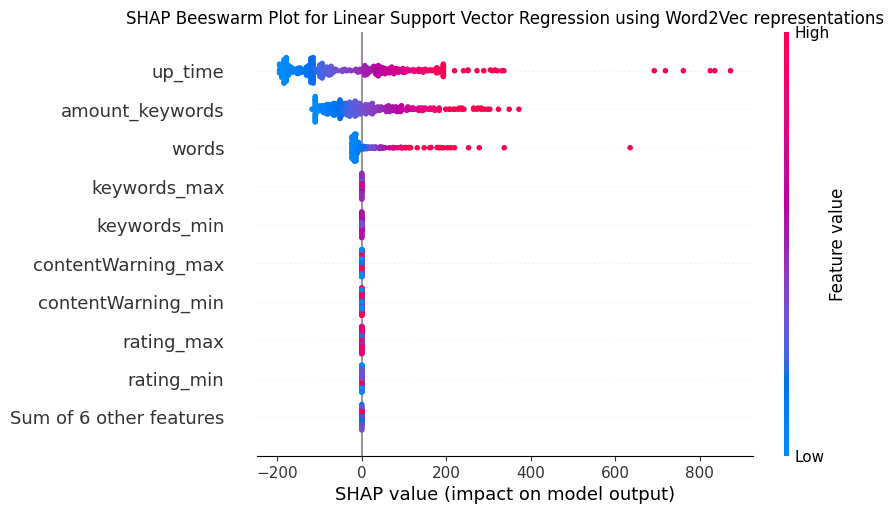

In [5]:
import shap
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def choose_model(algorithm):
    '''Chooses the model based on the given arguments.
    Returns the model with hyperparameters.
    '''
    # The Decision Trees model
    if algorithm == "Decision Trees":
        model = DecisionTreeRegressor(random_state=42, max_depth=4, splitter="random")

    # The Random Forest model
    elif algorithm == "Random Forest":
        model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=1)

    # The Linear Regression model
    elif algorithm == "Linear Regression":
        model = LinearRegression()

    # The SVR model
    elif algorithm == "Support Vector Regression":
        model = SVR(kernel="linear", C=12)

    # The Linear SVR model
    elif algorithm == "Linear Support Vector Regression":
        model = LinearSVR(random_state=42, loss="squared_epsilon_insensitive")

    return model


def shap_graphs(models, path_X, path_y):

    X = pd.read_csv(path_X)
    y = pd.read_csv(path_y)
    y = y["kudos"]

    X100 = shap.utils.sample(X, 100)

    # Train each model and analyze with SHAP
    for algorithm in models:
        model = choose_model(algorithm)
        model.fit(X, y)

        explainer = shap.Explainer(model.predict, X100)
        shap_values = explainer(X)

        if path_X[-7:] == "wTv.csv":
          vector = "Word2Vec"
        else:
          vector = "TF-IDF"


        title = f"SHAP Beeswarm Plot for {algorithm} using {vector} representations"
        shap.plots.beeswarm(shap_values, show=False)
        plt.title(title)
        plt.show()

def main():
    # List of models to train
    algorithms = ["Linear Regression", "Decision Trees", "Random Forest", "Linear Support Vector Regression"]

    shap_graphs(algorithms, "/content/data/all_X.csv", "/content/data/all_y.csv")
    shap_graphs(algorithms, "/content/data/all_X_wTv.csv", "/content/data/all_y_wTv.csv")

if __name__ == "__main__":
    main()
